In [159]:
import torch
import matplotlib.pyplot as plt

In [160]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [161]:
init_val = 0.05
iterations = 20
lr = 1.0

In [162]:
sam_out = {}
for rho in [0.01, 0.05]:
    sam_x = []
    sam_y = []
    sam_t = []
    x = torch.tensor(init_val, requires_grad=True)
    base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
    optimizer = SAM([x], base_optimizer, rho=rho, lr=lr)

    for i in range(iterations):
        sam_t.append(i + 1)
        sam_x.append(x.item())
        optimizer.zero_grad()
        y = x**2
        y.backward()
        optimizer.first_step(zero_grad=True)

        print(f"Iter {i} Step 1: x = {x}, y = {y}")

        y = x**2
        y.backward()
        optimizer.second_step(zero_grad=True)

        print(f"Iter {i} Step 2: x = {x}, y = {y}")

        sam_y.append(y.item())
    sam_out[rho] = [sam_x, sam_y, sam_t]

Iter 0 Step 1: x = 0.06000000238418579, y = 0.002500000176951289
Iter 0 Step 2: x = -0.07000000774860382, y = 0.0036000001709908247
Iter 1 Step 1: x = -0.08000000566244125, y = 0.004900000989437103
Iter 1 Step 2: x = 0.09000000357627869, y = 0.006400000769644976
Iter 2 Step 1: x = 0.10000000149011612, y = 0.008100000210106373
Iter 2 Step 2: x = -0.10999999940395355, y = 0.010000000707805157
Iter 3 Step 1: x = -0.11999999731779099, y = 0.01209999993443489
Iter 3 Step 2: x = 0.12999999523162842, y = 0.014399999752640724
Iter 4 Step 1: x = 0.14000000059604645, y = 0.016899999231100082
Iter 4 Step 2: x = -0.15000000596046448, y = 0.019600000232458115
Iter 5 Step 1: x = -0.1600000113248825, y = 0.02250000089406967
Iter 5 Step 2: x = 0.17000001668930054, y = 0.025600003078579903
Iter 6 Step 1: x = 0.18000002205371857, y = 0.02890000492334366
Iter 6 Step 2: x = -0.1900000274181366, y = 0.03240000829100609
Iter 7 Step 1: x = -0.20000003278255463, y = 0.03610001131892204
Iter 7 Step 2: x = 0.21

In [163]:
sgd_x = []
sgd_y = []
sgd_t = []
x = torch.tensor(init_val, requires_grad=True)
optimizer = torch.optim.SGD([x], lr=lr)

for i in range(iterations):
    sgd_t.append(i + 1)
    sgd_x.append(x.item())
    optimizer.zero_grad()
    y = x**2
    y.backward()
    optimizer.step()
    
    print(f"Iter {i}: x = {x}, y = {y}")
    
    sgd_y.append(y.item())

Iter 0: x = -0.05000000074505806, y = 0.002500000176951289
Iter 1: x = 0.05000000074505806, y = 0.002500000176951289
Iter 2: x = -0.05000000074505806, y = 0.002500000176951289
Iter 3: x = 0.05000000074505806, y = 0.002500000176951289
Iter 4: x = -0.05000000074505806, y = 0.002500000176951289
Iter 5: x = 0.05000000074505806, y = 0.002500000176951289
Iter 6: x = -0.05000000074505806, y = 0.002500000176951289
Iter 7: x = 0.05000000074505806, y = 0.002500000176951289
Iter 8: x = -0.05000000074505806, y = 0.002500000176951289
Iter 9: x = 0.05000000074505806, y = 0.002500000176951289
Iter 10: x = -0.05000000074505806, y = 0.002500000176951289
Iter 11: x = 0.05000000074505806, y = 0.002500000176951289
Iter 12: x = -0.05000000074505806, y = 0.002500000176951289
Iter 13: x = 0.05000000074505806, y = 0.002500000176951289
Iter 14: x = -0.05000000074505806, y = 0.002500000176951289
Iter 15: x = 0.05000000074505806, y = 0.002500000176951289
Iter 16: x = -0.05000000074505806, y = 0.00250000017695128

In [164]:
asam_out = {}
for rho in [0.01, 0.05]:
    asam_x = []
    asam_y = []
    asam_t = []
    x = torch.tensor(init_val, requires_grad=True)
    base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
    optimizer = SAM([x], base_optimizer, rho=rho, adaptive=True, lr=lr)

    for i in range(iterations):
        asam_t.append(i + 1)
        asam_x.append(x.item())
        optimizer.zero_grad()
        y = x**2
        y.backward()
        optimizer.first_step(zero_grad=True)

        print(f"Iter {i} Step 1: x = {x}, y = {y}")

        y = x**2
        y.backward()
        optimizer.second_step(zero_grad=True)

        print(f"Iter {i} Step 2: x = {x}, y = {y}")

        asam_y.append(y.item())
    asam_out[rho] = [asam_x, asam_y, asam_t]

Iter 0 Step 1: x = 0.05050000175833702, y = 0.002500000176951289
Iter 0 Step 2: x = -0.05100000277161598, y = 0.0025502501521259546
Iter 1 Step 1: x = -0.051510002464056015, y = 0.0026010002475231886
Iter 1 Step 2: x = 0.05202000215649605, y = 0.002653280273079872
Iter 2 Step 1: x = 0.05254020169377327, y = 0.002706080675125122
Iter 2 Step 2: x = -0.05306040123105049, y = 0.00276047270745039
Iter 3 Step 1: x = -0.05359100550413132, y = 0.002815406071022153
Iter 3 Step 2: x = 0.05412160977721214, y = 0.0028719957917928696
Iter 4 Step 1: x = 0.05466282740235329, y = 0.002929148729890585
Iter 4 Step 2: x = -0.05520404502749443, y = 0.002988024614751339
Iter 5 Step 1: x = -0.055756084620952606, y = 0.0030474865343421698
Iter 5 Step 2: x = 0.05630812421441078, y = 0.0031087410170584917
Iter 6 Step 1: x = 0.0568712055683136, y = 0.003170604817569256
Iter 6 Step 2: x = -0.057434286922216415, y = 0.0032343340571969748
Iter 7 Step 1: x = -0.05800862982869148, y = 0.003298697294667363
Iter 7 Ste

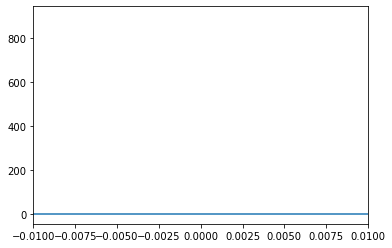

In [165]:
import numpy as np

# create 1000 equally spaced points between -10 and 10
x = np.linspace(-30, 30, 100)

# calculate the y value for each element of the x vector
y = x**2

fig, ax = plt.subplots()
plt.xlim(-0.01, 0.01)
ax.plot(x, y)
ax.scatter(sgd_x, sgd_y)

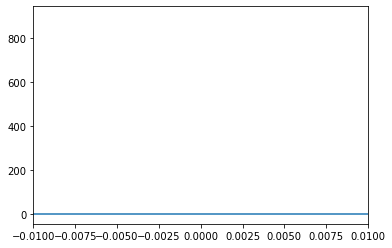

In [166]:
fig, ax = plt.subplots()
plt.xlim(-0.01, 0.01)
ax.plot(x, y)
ax.scatter(sam_x, sam_y)

Text(0.5, 1.0, 'Learning Rate = 1.0')

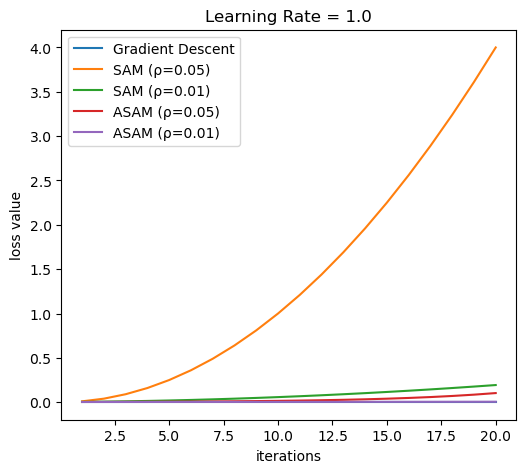

In [171]:
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.subplots_adjust(left=0.09, right=1,wspace=500, hspace=0.25, bottom=0.13, top=0.91)


ax = fig.add_subplot(1, 1, 1)
ax.plot(sgd_t, sgd_y, label='Gradient Descent')
ax.plot(sam_out[0.05][2], sam_out[0.05][1], label='SAM (ρ=0.05)')
ax.plot(sam_out[0.01][2], sam_out[0.01][1], label='SAM (ρ=0.01)')
ax.plot(asam_out[0.05][2], asam_out[0.05][1], label='ASAM (ρ=0.05)')
ax.plot(asam_out[0.01][2], asam_out[0.01][1], label='ASAM (ρ=0.01)')
ax.legend()
ax.set_xlabel("iterations")
ax.set_ylabel("loss value")
ax.set_title(f'Learning Rate = {lr}')